## Predicting Heart Arrhythmia
### Project Aim 
Research and development of algorithms to detect and classify arrhythmias (irregular heartbeats) using ECG (electrocardiogram) signals.

### Dataset Description 
The dataset **St. Petersburg INCART 12-lead Arrhythmia Database** ([link](https://physionet.org/static/published-projects/incartdb/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip)) contains **12-lead ECG recordings** sampled at **257 Hz** from 75 subjects, annotated by experts for arrhythmia detection.
- Subjects: The dataset contains recordings from 75 subjects
- Leads: Each recording is a 12-lead ECG, which provides a comprehensive view of the heart's electrical activity from multiple angles. 
- Sampling Rate: The ECG signals are sampled at 257 Hz, meaning ECG signal is measured 257 times per second.
- Annotations: The dataset includes annotations that label specific points in the ECG recordings, such as the onset of arrhythmias, types of arrhythmias, and other relevant cardiac events.


### Project Set up and Data loading 

In [1]:
%pip install wfdb

In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
import zipfile
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score,f1_score
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [2]:
dataset_url = "https://physionet.org/static/published-projects/incartdb/st-petersburg-incart-12-lead-arrhythmia-database-1.0.0.zip"
dataset_zip_path = "incartdb.zip"
dataset_extract_path = "incartdb_dataset"
if not os.path.exists(dataset_zip_path):
    print("Downloading INCART 12-lead Arrhythmia Database...")
    urllib.request.urlretrieve(dataset_url, dataset_zip_path)
    print("Download completed.")
if not os.path.exists(dataset_extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall(dataset_extract_path)
    print("Extraction completed.")

### Data Loading

In [3]:
def load_ECG_file(path):
    '''
    Input:
        path: Path to the patient file (excluding the extension)
    Output:
        signal: ECG signal (lead I by default)
        symbol: Annotation symbols (heartbeat types)
        index: Annotation indices (sample positions of heartbeats)
    '''
    record = wfdb.rdrecord(path)  # Load ECG signal
    annotation = wfdb.rdann(path, 'atr')  # Load annotations
    signal = record.p_signal[:, 0]  # Select lead I (first lead)
    symbol = annotation.symbol  # Extract annotation symbols
    index = annotation.sample  # Extract annotation indices
    return signal, symbol, index
path_dataset = '/home/en520-yduan20/scr4-en520-lmorove1/incartdb_dataset/files/'
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, 'I48'))
print(f'Length of signal: {len(signal)}')  # Length of ECG signal (in samples)
print(f'Annotation symbols (first 10): {symbol[:100]}')  # First 100 annotation symbols
print(f'Annotation indices (first 10): {index[:100]}')  # First 100 annotation indices
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

Length of signal: 462600
Annotation symbols (first 10): ['N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Annotation indices (first 10): [  209   446   676   906  1102  1231  1555  1778  1979  2110  2339  2528
  2740  2873  3158  3361  3542  3676  3892  4071  4287  4487  4695  4881
  5059  5256  5480  5617  5900  6073  6281  6415  6711  6932  7110  7241
  7461  7642  7862  8069  8285  8477  8663  8796  9113  9308  9498  9630
  9909 10081 10305 10512 10725 10912 11085 11257 11449 11669 11806 12095
 12277 12456 12670 12882 13097 13291 13481 1360

### Inspecting and ploting a Random 10-Second ECG Segment 

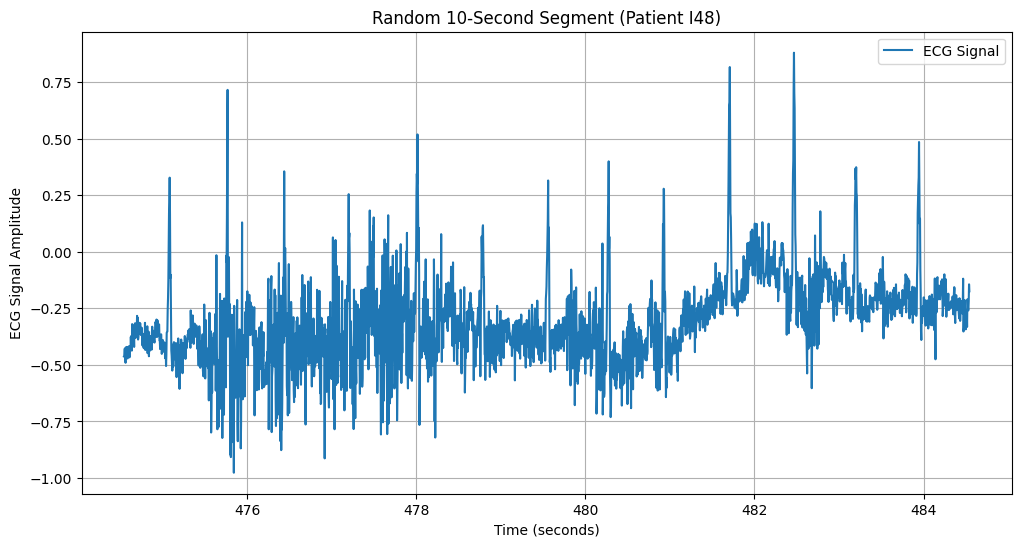

In [4]:
sampling_rate = 257 
start = np.random.randint(0, len(signal) - 10*sampling_rate) 
end = start + 10*sampling_rate  
time_axis = np.arange(start, end) / sampling_rate 

plt.figure(figsize=(12, 6))
plt.plot(time_axis, signal[start:end], label='ECG Signal')
plt.title('Random 10-Second Segment (Patient I48)')
plt.xlabel('Time (seconds)')
plt.ylabel('ECG Signal Amplitude')
plt.grid(True)
plt.legend()
plt.show()

### Inspecting and Plotting a 1-Second Abnormal Segment

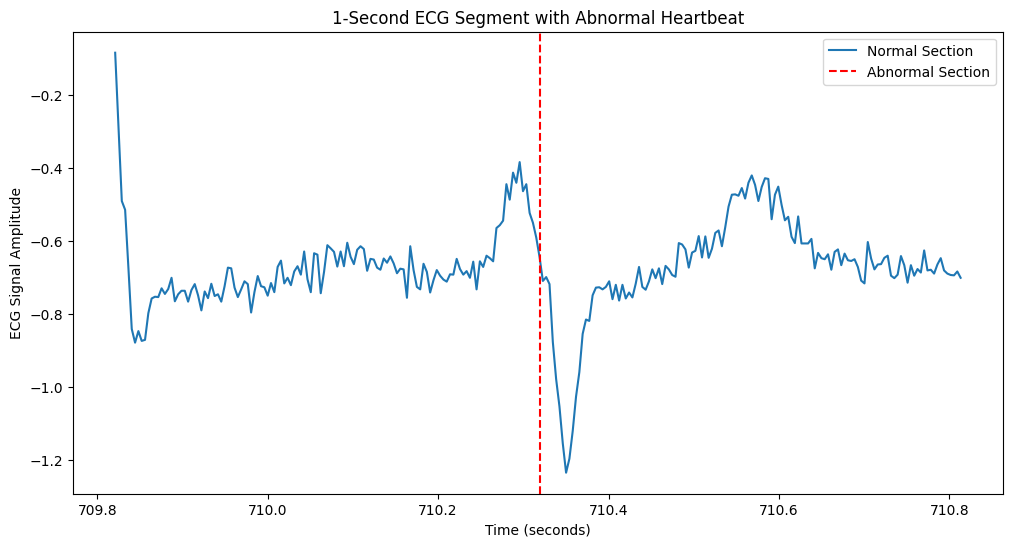

In [5]:
abnormal_indices = [i for i, s in zip(index, symbol) if s in abnormal]
abnormal_index = abnormal_indices[len(abnormal_indices) // 2]
start_1s = abnormal_index - sampling_rate// 2
end_1s =  abnormal_index + sampling_rate // 2
time_1s = np.arange(start_1s, end_1s) / sampling_rate 
plt.figure(figsize=(12, 6))
plt.plot(time_1s, signal[start_1s:end_1s], label="Normal Section")
plt.axvline(x=abnormal_index / sampling_rate, color='r', linestyle='--', label="Abnormal Section")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Signal Amplitude")
plt.title("1-Second ECG Segment with Abnormal Heartbeat")
plt.legend()
plt.show()

### Constructing Data Matrix
Construct the data matrix \( X \) and the corresponding label vector $y \in \mathbb{R}^{N\times 1}$, where:  
- **Label 0:** Normal  
- **Label 1:** Abnormal  

All symbols in the abnormal list must be labeled as **1**. The patients in the **training set** and **test set** must be **mutually exclusive** as the given pattern

In [6]:
# training patient IDs
pts_train = [f'I{str(i).zfill(2)}' for i in range(1, 31)]
print(pts_train)

# testing patient IDs
pts_test = [f'I{str(i).zfill(2)}' for i in range(31, 41)]
print(pts_test)

['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30']
['I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40']


In [7]:
def make_dataset(pts, num_sec, fs, abnormal):
    '''
    Create a dataset from ECG signals by extracting specific segments around heartbeats
    and labeling them based on the presence of abnormalities.

    Parameters:
    - pts: List of patient identifiers to load ECG files for processing.
    - num_sec (float): Number of seconds to include before and after each heartbeat in the extracted segment.
    - fs (int): Sampling frequency of the ECG signals, used to calculate the number of samples in each segment.
    - abnormal: List of abbreviations for abnormalities to look for in the ECG signals.

    Returns:
    - X_all (numpy.ndarray): Signal matrix with shape (nbeats, 2 * num_sec * fs).
    - Y_all (numpy.ndarray): Binary labels matrix with shape (nbeats, 1), indicating abnormality presence.
    '''
    
    X_all = []
    Y_all = []
    num_samples = int(num_sec * fs )
    for pt in pts:
        signal, symbol, index = load_ECG_file(os.path.join(path_dataset, pt))
        for i, idx in enumerate(index):
            start = idx - num_samples
            end = idx + num_samples
            if start >= 0 and end < len(signal):
                segment = signal[start:end]
                X_all.append(segment)
                if symbol[i] in abnormal:
                    Y_all.append(1)
                else:
                    Y_all.append(0)
    X_all = np.array(X_all)
    Y_all = np.array(Y_all).reshape(-1, 1)
    return X_all, Y_all

In [8]:
# Check the abnormal data / normal data ratio for training and testing set
def check_ratio(y_train, y_test):
    # Training set
    train_normal = np.sum(y_train == 0)
    train_abnormal = np.sum(y_train == 1)
    ratio_train = train_abnormal/train_normal
    print("Training set normal points:", train_normal )
    print("Training set abnormal points:",train_abnormal)
    print("Ratio:", ratio_train )
    # Test set
    test_normal = np.sum(y_test == 0)
    test_abnormal = np.sum(y_test == 1)
    ratio_test = test_abnormal/test_normal
    print("Testing set normal points:", test_normal )
    print("Testing set abnormal points:",test_abnormal)
    print("Ratio:", ratio_test )

num_sec = 0.5  
fs = 257       
X_train, y_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_test, y_test = make_dataset(pts_test, num_sec, fs, abnormal)
check_ratio(y_train, y_test)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Training set normal points: 61705
Training set abnormal points: 9497
Ratio: 0.15390973178834777
Testing set normal points: 20914
Testing set abnormal points: 4892
Ratio: 0.23391029932102897
Shape of X_train: (71202, 256)
Shape of y_train: (71202, 1)


### Feature Extraction 

In [12]:
import numpy as np
from scipy import signal
def extract_features(X):
    '''
    Extracts time-frequency features from ECG segments using Short-Time Fourier Transform (STFT).

    Parameters:
    - X (numpy.ndarray): Input data matrix of shape (N, D), where
      N = number of segments, D = number of samples per segment.

    Returns:
    - X_features (numpy.ndarray): Feature matrix of shape (N, Time, Frequency).
    '''
    X_features = []
    for segment in X:
        f, t, Sxx = signal.spectrogram(segment, fs=257, nperseg=64, noverlap=32)
        X_features.append(Sxx.T)
    return np.array(X_features)

# Feature extraction for training and testing datasets
F_train = extract_features(X_train)
F_test = extract_features(X_test)
# Output the shape of extracted features
print(f"F_train shape: {F_train.shape}, F_test shape: {F_test.shape}")

F_train shape: (71202, 7, 33), F_test shape: (25806, 7, 33)


### Distribution and Compensatin for Imbalance

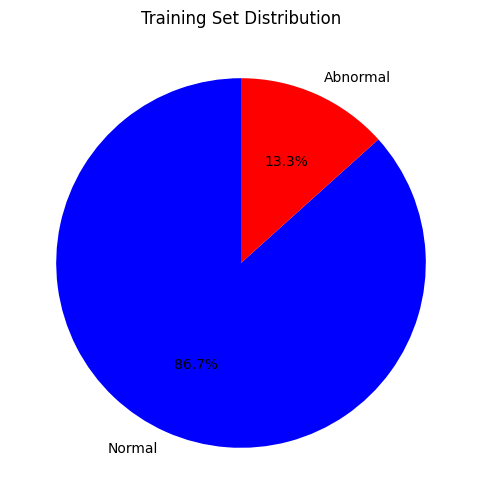

In [13]:
normal_train = np.sum(y_train == 0)
abnormal_train = np.sum(y_train == 1)
normal_percent_train = (normal_train / len(y_train)) * 100
abnormal_percent_train = (abnormal_train / len(y_train)) * 100
labels = ['Normal', 'Abnormal']
plt.figure(figsize=(8, 6))
plt.pie([normal_percent_train, abnormal_percent_train], labels=labels, colors=['blue', 'red'], autopct='%1.1f%%', startangle=90)
plt.title('Training Set Distribution')
plt.show()

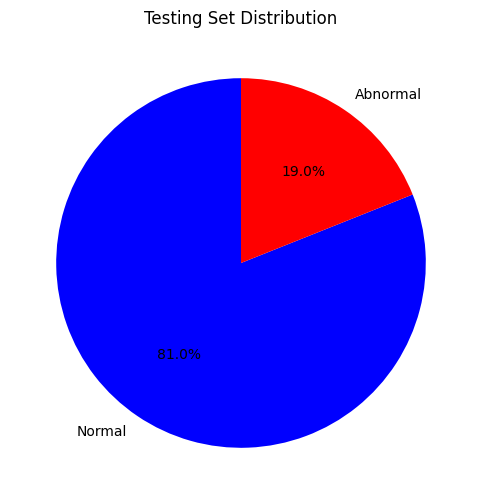

In [14]:
normal_test = np.sum(y_test == 0)
abnormal_test = np.sum(y_test == 1)
normal_percent_test = (normal_test / len(y_test)) * 100
abnormal_percent_test = (abnormal_test / len(y_test)) * 100
labels = ['Normal', 'Abnormal']
plt.figure(figsize=(8, 6))
plt.pie([normal_percent_test, abnormal_percent_test], labels=labels, colors=['blue', 'red'], autopct='%1.1f%%', startangle=90)
plt.title('Testing Set Distribution')
plt.show()

In [16]:
def mybce(yhat, y, pos_weight=3, eps=1e-7):
    """
    Custom Binary Cross-Entropy (BCE) loss function with numerical stability and adjustable positive class weight.

    Parameters:
    - yhat (Tensor): Predicted probabilities (should be in the range [0, 1])
    - y (Tensor): Ground truth labels (0 or 1)
    - pos_weight (float): Weight for the positive class to handle class imbalance
    - eps (float): Small constant to prevent log(0) errors

    Returns:
    - loss (Tensor): Computed BCE loss
    """
    yhat = torch.clamp(yhat, eps, 1 - eps)
    loss = -torch.mean(pos_weight * y * torch.log(yhat) + (1 - y) * torch.log(1 - yhat))
    return loss

### Implementing Neural Networks 
- Bidirectional LSTM
- 1D-CNN
- AlexNet

In [17]:
### Data Setup 
F_train = torch.from_numpy(F_train).float()
F_test= torch.from_numpy(F_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
class GetLSTMOutput(nn.Module):
    def forward(self, x):
        out,_ = x
        return out


train_dataset = TensorDataset(F_train, y_train)
test_dataset = TensorDataset(F_test, y_test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Bidirectional LSTM

In [19]:
input_size = F_train.shape[2]  
hidden_size = 64  
num_layers = 1  
bidirectional = True  
output_size = 1 
sequence_length = F_train.shape[1]

model = nn.Sequential(
    nn.LSTM(
        input_size=input_size,  
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        bidirectional=bidirectional,  
        batch_first=True  
    ),
    GetLSTMOutput(),
    nn.Flatten(start_dim=1), 
    nn.Linear(hidden_size * 2 * sequence_length, output_size),  
    nn.Sigmoid()
)

In [20]:
def weighted_bce_loss(yhat, y):
    return mybce(yhat, y, pos_weight=3)
criterion = weighted_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda")
model = model.to(device)
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

In [21]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    losses = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        predicted = (output > 0.5).float() 
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = losses / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10], Loss: 0.715, Accuracy: 87.61%
Epoch [2/10], Loss: 0.415, Accuracy: 92.70%
Epoch [3/10], Loss: 0.348, Accuracy: 93.97%
Epoch [4/10], Loss: 0.337, Accuracy: 94.26%
Epoch [5/10], Loss: 0.296, Accuracy: 94.97%
Epoch [6/10], Loss: 0.283, Accuracy: 95.04%
Epoch [7/10], Loss: 0.269, Accuracy: 95.28%
Epoch [8/10], Loss: 0.256, Accuracy: 95.47%
Epoch [9/10], Loss: 0.245, Accuracy: 95.63%
Epoch [10/10], Loss: 0.225, Accuracy: 95.88%


In [22]:
# Evaluate the model on the test data, print test accuracy and F1-score
from sklearn.metrics import accuracy_score, f1_score
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        predicted = (output > 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(target.cpu().numpy())
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions )
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1-Score: {f1:.3f}")

Test Accuracy: 84.78%
Test F1-Score: 0.621


#### 1-D CNN

In [23]:
class ConvModel(nn.Module):
    def __init__(self,input_channels=7, num_classes=1, input_length=32):
        # Your code here
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flattened_size = 128 * (input_length // 8)  
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))      
        return x

In [24]:
input_length = F_train.shape[2] 
model = ConvModel(input_channels=7, num_classes=1, input_length=input_length)
pos_weight = 3
criterion = weighted_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda")
model = model.to(device)
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

In [25]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  
    losses = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        predicted = (output > 0.5).float() 
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = losses / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10], Loss: 0.576, Accuracy: 89.79%
Epoch [2/10], Loss: 0.259, Accuracy: 95.26%
Epoch [3/10], Loss: 0.222, Accuracy: 96.06%
Epoch [4/10], Loss: 0.210, Accuracy: 96.46%
Epoch [5/10], Loss: 0.219, Accuracy: 96.32%
Epoch [6/10], Loss: 0.207, Accuracy: 96.50%
Epoch [7/10], Loss: 0.193, Accuracy: 96.69%
Epoch [8/10], Loss: 0.188, Accuracy: 96.77%
Epoch [9/10], Loss: 0.181, Accuracy: 96.91%
Epoch [10/10], Loss: 0.184, Accuracy: 96.81%


In [26]:
from sklearn.metrics import accuracy_score, f1_score
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = to_device(data, device), to_device(target, device)
        output = model(data)
        predicted = (output > 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(target.cpu().numpy())
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions )
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1-Score: {f1:.3f}")

Test Accuracy: 79.81%
Test F1-Score: 0.570


#### Alex-Net
- Using Structure below
- ![AlexNet](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=166618&s=150&r=1&c=1)

In [33]:
class AlexNet1D(nn.Module):
    def __init__(self, num_classes=1, input_channels=7, input_length=1000):
        """
        Args:
            num_classes (int): Number of output classes (1 for binary classification).
            input_channels (int): Number of input channels (e.g., ECG leads).
            input_length (int): Length of the input signal (e.g., number of time steps).
        """
        super(AlexNet1D, self).__init__()
        self.input_channels = input_channels
        self.input_length = input_length
        self.features = nn.Sequential(
            # Layer 1: Conv1d -> ReLU -> MaxPool1d
            nn.Conv1d(input_channels, 96, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),  

            # Layer 2: Conv1d -> ReLU -> MaxPool1d
            nn.Conv1d(96, 256, kernel_size=5, padding=2),  
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),  

            # Layer 3: Conv1d -> ReLU
            nn.Conv1d(256, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),

            # Layer 4: Conv1d -> ReLU
            nn.Conv1d(384, 384, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),

            # Layer 5: Conv1d -> ReLU -> MaxPool1d
            nn.Conv1d(384, 256, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),  
        )

        self.flattened_size = self._get_flattened_size()
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid() 
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, self.input_length)  
            dummy_output = self.features(dummy_input)
            return dummy_output.view(1, -1).size(1) 

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ========== Define AlexNet1D Model ==========
class AlexNet1D(nn.Module):
    def __init__(self, num_classes=1, input_channels=7, input_length=1000):
        super(AlexNet1D, self).__init__()
        self.input_channels = input_channels
        self.input_length = input_length

        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 96, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv1d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv1d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )

        self.flattened_size = self._get_flattened_size()
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, self.input_length)
            dummy_output = self.features(dummy_input)
            return dummy_output.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


# ========== Prepare Model ==========
input_channels = F_train.shape[1]
input_length = F_train.shape[2]
model = AlexNet1D(num_classes=1, input_channels=input_channels, input_length=input_length)

criterion = weighted_bce_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ========== Training ==========
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.2f}%")


# ========== Evaluation ==========
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output > 0.5).float()

        predictions.extend(predicted.cpu().numpy())
        targets.extend(target.cpu().numpy())

predictions = np.ravel(predictions)
targets = np.ravel(targets)
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions, zero_division=0)  

print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1-Score: {f1:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(targets, predictions))
print("\nClassification Report:")
print(classification_report(targets, predictions, zero_division=0))


Epoch [1/10], Loss: 1769.9937, Accuracy: 86.59%
Epoch [2/10], Loss: 1764.8757, Accuracy: 86.66%
Epoch [3/10], Loss: 1762.7359, Accuracy: 86.66%
Epoch [4/10], Loss: 1763.0747, Accuracy: 86.66%
Epoch [5/10], Loss: 1761.2108, Accuracy: 86.66%
Epoch [6/10], Loss: 1760.2299, Accuracy: 86.66%
Epoch [7/10], Loss: 1760.6944, Accuracy: 86.66%
Epoch [8/10], Loss: 1760.4771, Accuracy: 86.66%
Epoch [9/10], Loss: 1759.6894, Accuracy: 86.66%
Epoch [10/10], Loss: 1760.8198, Accuracy: 86.66%

Test Accuracy: 81.04%
Test F1-Score: 0.000

Confusion Matrix:
[[20914     0]
 [ 4892     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90     20914
         1.0       0.00      0.00      0.00      4892

    accuracy                           0.81     25806
   macro avg       0.41      0.50      0.45     25806
weighted avg       0.66      0.81      0.73     25806



### Conclusion 
| Model              | Final Train Accuracy | Final Train Loss | Test Accuracy | Test F1-Score | Class 1 Prediction      |
|--------------------|----------------------|------------------|---------------|---------------|--------------------------|
| **BiLSTM**         | 95.88%               | 0.225            | **84.78%**    | **0.621**     | Yes (moderate recall) |
| **1D CNN**         | **96.81%**           | 0.184            | 79.81%        | 0.570         | Yes (weaker recall)   |
| **AlexNet1D**      | 86.66%               | ~1760            | 81.04%        | **0.000**     | Only predicts class 0 |

The Bidirectional LSTM shows the best overall performance, especially in handling class imbalance, achieving the highest F1-score and solid test accuracy. The 1D CNN also performs well with slightly higher training accuracy but shows signs of overfitting. In contrast, AlexNet1D completely fails to detect class 1, highlighting its architectural unsuitability for this binary 1D classification task.
